# Bayesian Linear Regression Construction with Pyro

One of the most beneficial uses for probabilistic programming is the construction of probabilistic machine learning models.

Generally speaking, machine learning models are designed as functions, or mappings, from an input to an output. We have some input $X$ which is an $m\times n$ matrix of $m$ data points with $n$ features each, and we want to construct some mapping $f$ which transforms the features into predictions of some unknown values $\vec{y} = \mathbb{R}^n$

in essence, we're interested in a function:

$$f(X) = y$$

https://math.embed.fun/8HzEmimwFL2Fi8uTdiPFqr

and we'd like our ML models to approximate it as best as possible, ideally while also giving us an idea for **why** the produced certain predictions.

One of the basic ML models which accomplishes both is the linear regression which simply maps $y$ as a linear response of $X$ given some coefficients, $\beta$, such that

$$ y = \beta X$$

However, one major drawback of simple linear regressions is that they create point estimates of $\beta$ without taking uncertainty into account. In this article we'll discuss how to leverage PyTorch and Pyro to produce linear regression models which create uncertainty estimates both for the parameters, as well as for predictions.

## Employing Scikit-learn's Linear Regression

We'll start by exploring a simple linear regression from `sklearn`, and see how it behaves on one of the built in datasets in `sklearn`, the California Housing dataset.

We'll start by importing all our required libraries

In [1]:
import numpy as np
import time
np.set_printoptions(suppress=True)


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Now let's import the housing dataset, and explore its features

In [2]:
super_start = time.time()
super_results = pd.DataFrame({'LR' :[], 
                 'MCMC unscaled normal': [], 
                 'MCMC scaled normal': [], 
                 'MCMC gamma': [],  
                 'SVI gamma': []})


from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

X = california.data
y = california.target * 100000

print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')

Data shape is (20640, 8)
Target shape is (20640,)


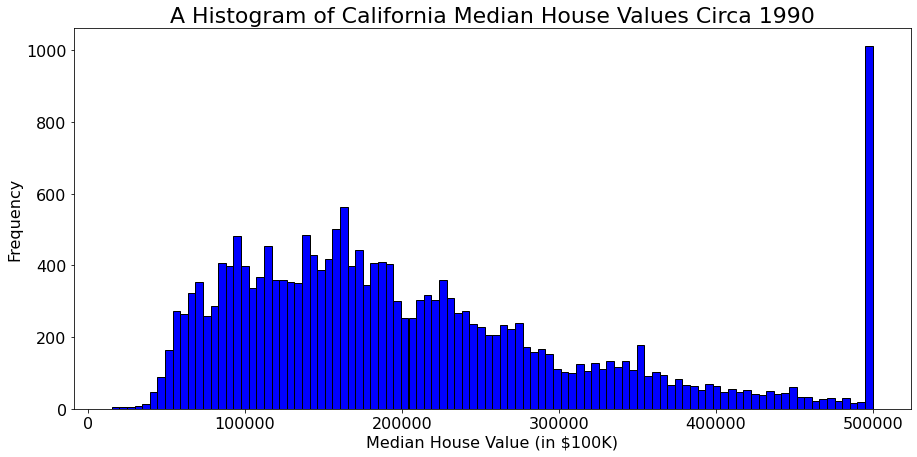

In [3]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig("HouseValues.png", dpi=36*4)
plt.show()



There are two important observations to be made from this data; First, the distribution of prices is not normal, it is closer to a Gamma distribution. Second, there is a very sharp spike of instances at the \\$500,000 mark, this can an indication of "censored" data. In essence, the data might have been recorded up to \\$500,000, at which point it was recorded as "\\$500,000+"

Let's explore how well a linear regression performs on this data:

In [4]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(16512, 8) (16512,)
(4128, 8) (4128,)


In [5]:
max_threshold = y_train.max()

my_linear_regression = LinearRegression().fit(X_train,y_train)

print(my_linear_regression.intercept_)
print(my_linear_regression.coef_)

y_pred = my_linear_regression.predict(X_test)

super_results.loc['runtime', 'LR'] = 0.0

y_small = y_test[y_test<max_threshold]
y_pred_small = y_pred[y_test<max_threshold]

y_pred = np.where(y_pred > max_threshold, max_threshold, y_pred)

-3675177.7363863355
[ 44041.73202484    953.78071022 -11581.35113962  66421.73229961
     -0.26552073   -464.47774797 -41712.49871004 -43177.09077796]


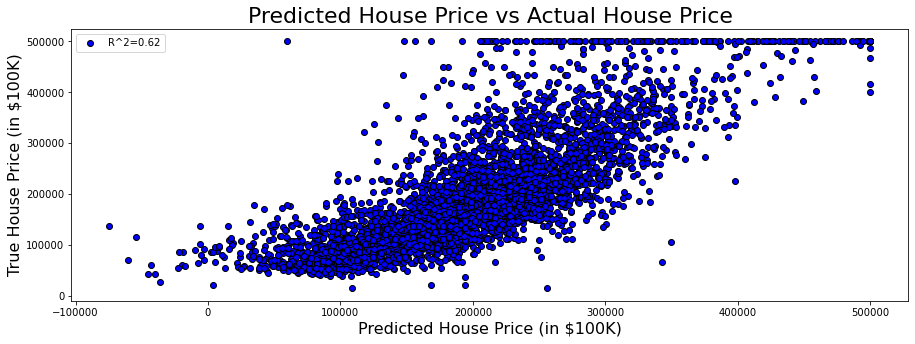

In [6]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [7]:
super_results.loc['R^2 censored', 'LR'] = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.6239332401038957

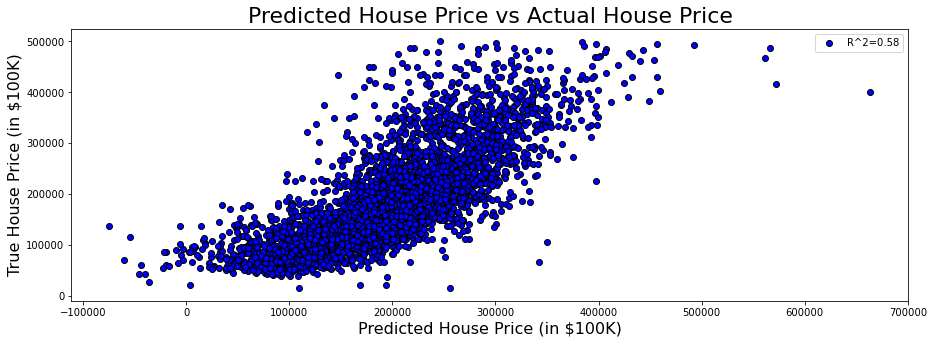

In [8]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [9]:
super_results.loc['R^2 small', 'LR'] = r2_score(y_small, y_pred_small)
r2_score(y_small, y_pred_small)

0.5762494972831974

While this approach can produce satisfactory results, it suffers from a few main drawbacks; 

* First, the linear model generally ignore the fact that the prices come from a Gamma distribution. Its calculations of the expected value for every point are predicated on the mean coming from a Normal distribution. 
* Second, and more importantly, the simple linear model takes the censored data at face value. That is, it believes the prices of all houses registered as "+\\$500,000" to be \\$500,000. This might cause it to underestimate the effect some features have on house price.
* Third, for each coefficient, we only get a point estimate of its most likely value (under certain incorrect assumptions). However, we might be interested in a range which accounts for uncertainty. For example, we might want to know what is the range of price increases we can expect for each additional bedroom.

To address these problems, we can employ Pyro and PyTorch to construct our own linear model which will address all the pain points just mentioned. 

## Step I - Reconstructing the Linear Model with Pyro

First, let's try and replicate the findings of the simple linear regression with Pyro. This will give us an intuition for how the different Pyro primitives work

In [10]:
# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS


# We'll be timing our execution as well
import time

First, we will define our model in Pyro. Pyro models are defined as functions (actually they are defined as callables, but the simplest callable is a function). The function will accept our features $X$, our target $y$, and also the feature names for easier naming of priors.

In [11]:
def model_normal(X, y, column_names):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    # Define a sigma value for the random error
    sigma = pyro.sample("sigma", dist.HalfCauchy(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In essence what we've done here is define our linear regression as the following linear combination of parameters


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \mathcal{N}(0, \sigma^2)$$

However, unlike traditional linear regressions, we've defined each beta coefficient, as well as the error term, to be a distribution instead of a single values. That is, for each coefficient, we can ask what is the range of possible values this coefficient can assume given the data we observed. We gave a name to each of those distributions (e.g. "`beta_intercept`") for easy reference later.

We had to define priors on each coefficient. A prior is like our "best guess" for that value. Our chosen priors were:

$$\beta_i \sim \mathcal{N}(0, 1)$$<br>
$$\sigma \sim \text{HalfCauchy}(0.0, 10.0)$$<br>


Once the priors are defined, we can ask Pyro to update them into better and better guesses through the magic of MCMC samplers

In [12]:
SAMPLE_NUMBER = 3000


# Turn out numpy data into PyTorch 
# tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)



# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal, max_tree_depth=7)

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then remove the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch, 
             y_train_torch,
             california.feature_names)

end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

super_results.loc['runtime', 'MCMC unscaled normal'] = round(end_time -  start_time, 2)



Sample: 100%|██████████| 3100/3100 [24:45,  2.09it/s, step size=8.23e-03, acc. prob=0.963]

Inference ran for 1486.01 seconds


I am not going to explain in detail how the sampling works here, but if you are interested in a breakdown of what has happened here, I recommend that you check out [my previous post](https://towardsdatascience.com/probabilistic-programming-with-pyro-and-kitchen-scale-f8d6a5d9ae0f) which explores the use of MCMC methods to optimize one parameter.

Once our sampler is finished, we can look at the summary data for each beta value.

In [13]:
my_mcmc1.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept     -0.09      0.95     -0.10     -1.60      1.49    162.75      1.00
      beta_MedInc      0.26      1.02      0.27     -1.39      1.88     69.88      1.00
    beta_HouseAge      1.99      1.02      2.02      0.27      3.57    175.97      1.01
    beta_AveRooms      0.29      0.96      0.33     -1.24      1.91     84.82      1.00
   beta_AveBedrms      0.03      0.93      0.04     -1.42      1.63     89.41      1.01
  beta_Population     53.90      0.64     53.90     52.84     54.89   3018.73      1.00
    beta_AveOccup      0.12      0.94      0.18     -1.47      1.70     84.18      1.03
    beta_Latitude      2.27      1.01      2.25      0.64      3.95    144.37      1.00
   beta_Longitude     -7.49      1.02     -7.48     -9.04     -5.73    663.02      1.00
            sigma 184470.17   1085.38 184466.48 182642.85 186218.53   2805.52      1.00

Number of divergences: 0


Let's grab the individual samples from our sampler, let's turn those into a dataframe (they are returned as a dictionary).
We can grab the mean of each distribution as a coefficient point estimate, and then calculate a set of predictions for our data points. Then we can compare them to our known values for house prices

In [14]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
beta_df

,beta_intercept,beta_MedInc,beta_HouseAge,beta_AveRooms,beta_AveBedrms,beta_Population,beta_AveOccup,beta_Latitude,beta_Longitude,sigma
0,0.386202,0.221395,2.284682,2.746440,1.625357,53.789455,1.246074,2.080305,-6.105422,185288.535931
1,-0.071276,0.416397,2.080332,2.886248,1.981830,53.758147,1.116496,2.289040,-6.520474,183544.602218
2,-0.235519,0.608028,2.694501,2.685197,1.692904,54.175301,0.909520,3.308471,-5.754859,183518.666326
3,-0.313217,0.641515,1.917846,2.553700,1.740860,54.014597,1.091723,3.062021,-6.259344,183588.305072
4,-0.282592,0.697371,2.004428,2.576774,1.671203,53.738883,1.141726,3.235432,-6.550524,183805.033233
...,...,...,...,...,...,...,...,...,...,...
2995,1.278092,1.029701,1.598223,0.845214,-0.124210,54.846367,0.357045,2.257677,-6.861856,183694.001965
2996,1.167799,1.180177,1.613853,0.800589,0.021617,54.195885,0.306733,2.135607,-6.834397,184144.749305
2997,1.034560,1.252744,1.792514,0.828884,-0.052134,52.624219,0.318953,2.100878,-6.970096,184345.231756
2998,1.055753,1.317341,1.749470,0.837336,-0.048640,53.850344,0.302202,2.101316,-7.070152,182737.873970


In [15]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df.iloc[:, :-1].mean()
    coefficients

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [16]:
linear_combination = predict_linear_combination(beta_df, X_test)

In [17]:
# Our predictions are the linear combination
y_pred = linear_combination

# Find all the predictions for houses below $500,000 in value
y_pred_small = y_pred[y_test<max_threshold]

# Censor our predictions as well
y_pred= np.where(y_pred > max_threshold, max_threshold, y_pred)

We can compare our entire dataset. As well as our estimate of non-censored data.

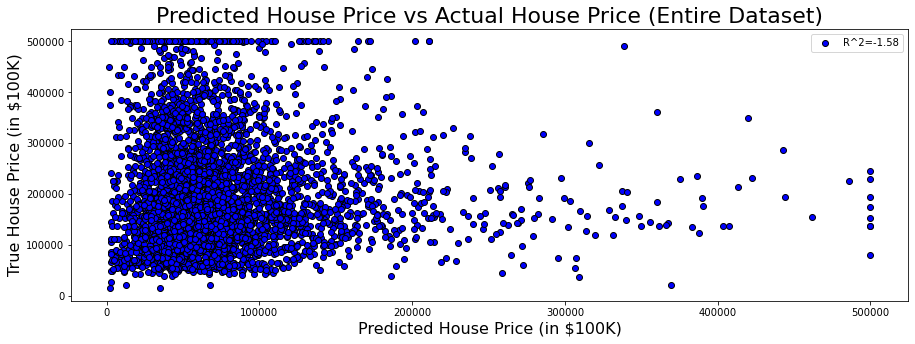

In [18]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price (Entire Dataset)", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [19]:
super_results.loc['R^2 censored', 'MCMC unscaled normal'] = r2_score(y_test, y_pred)
print(r2_score(y_test, y_pred))

-1.5839355085824596


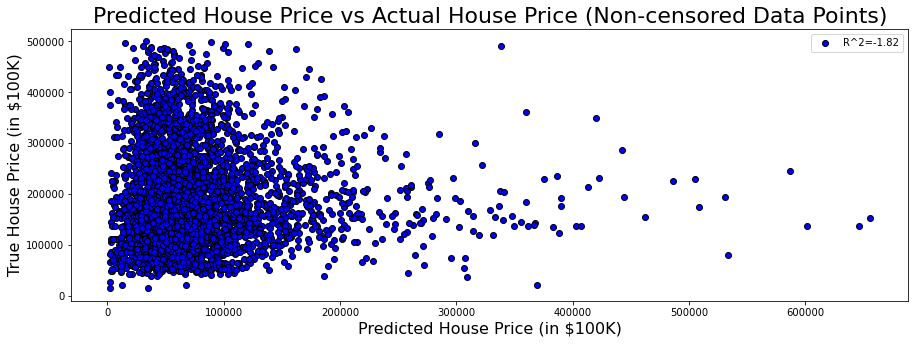

In [20]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price (Non-censored Data Points)", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [21]:
super_results.loc['R^2 small', 'MCMC unscaled normal'] = r2_score(y_small, y_pred_small)
print(r2_score(y_small, y_pred_small))

-1.8167106063252234


Well that looks like a disaster! What happened?

Let's define a function that will draw the coefficients' distributions for us when given a coefficient dataframe

In [22]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(5,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        ax.hist(beta_df[key], color="blue", edgecolor="black", bins=100)

    plt.subplots_adjust(hspace=0.5)

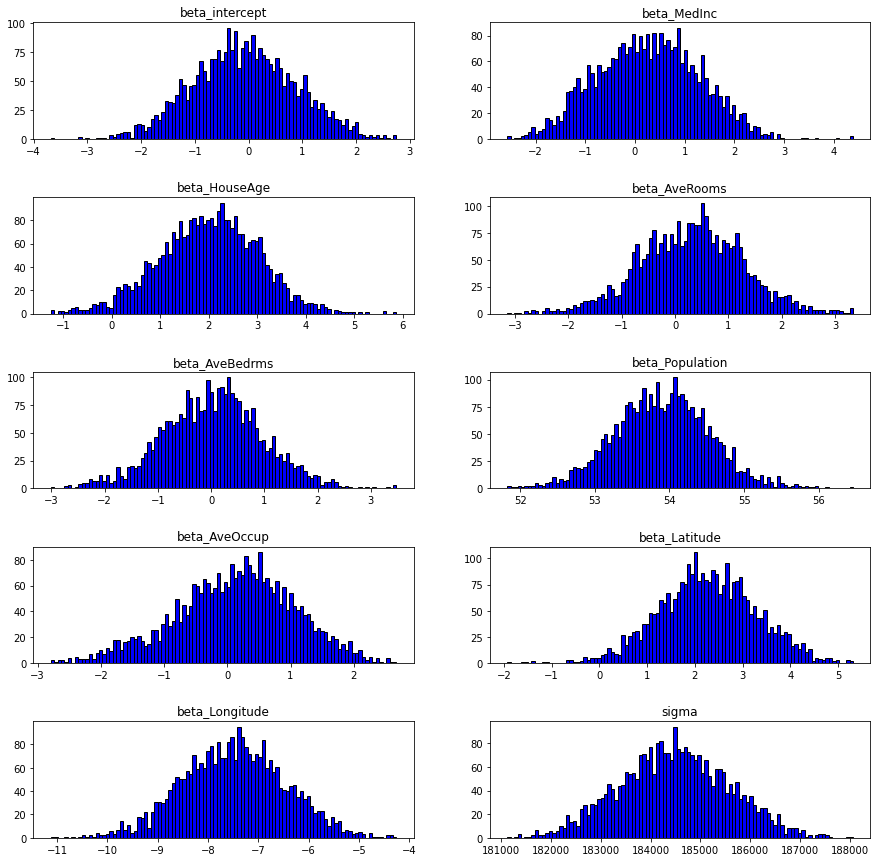

In [23]:
draw_coefficients(beta_df)

These look interesting... they don't look anything like the coefficients the linear regression from `sklearn` has found. 

Turns out MCMC methods have a hard time with different scales for our data. They work much better when our features and target are scaled. Let's explore the performance of the same methodology with the data scaled

## Scaled data

We are going to scale our X and y data using a standard scaler from `sklearn`. The standard scaler will scale each feature in X in such a way that it has a mean of 0.0, and a standard deviation of 1.0.

This means, instead of trying to find a set of coefficients on the original data


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n $$

we will find a set of coefficients on the scaled data:

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n} $$

Where 

$$y' = \frac{y}{max(y)}$$

That is y is scaled to be between 0-1 and the columns of X have been standardized.

In [24]:
from sklearn.preprocessing import StandardScaler

my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

y_max = y_train.max()
y_train_scaled = y_train/y_max

In [25]:
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


pyro.clear_param_store()
my_kernel = NUTS(model_normal, max_tree_depth=7)


my_mcmc2 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc2.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')
super_results.loc['runtime', 'MCMC scaled normal'] = round(end_time -  start_time, 2)



my_mcmc2.summary()

Sample: 100%|██████████| 3100/3100 [05:05, 10.16it/s, step size=2.85e-03, acc. prob=0.912]


Inference ran for 305.14 seconds

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      0.41      0.00      0.41      0.41      0.42   4884.39      1.00
      beta_MedInc      0.17      0.00      0.17      0.16      0.17   1072.03      1.00
    beta_HouseAge      0.02      0.00      0.02      0.02      0.03   2700.82      1.00
    beta_AveRooms     -0.05      0.00     -0.05     -0.06     -0.05   1086.41      1.00
   beta_AveBedrms      0.06      0.00      0.06      0.06      0.06   1244.68      1.00
  beta_Population     -0.00      0.00     -0.00     -0.00      0.00    999.19      1.00
    beta_AveOccup     -0.01      0.00     -0.01     -0.01     -0.00   3803.82      1.00
    beta_Latitude     -0.18      0.00     -0.18     -0.18     -0.17   1396.64      1.00
   beta_Longitude     -0.17      0.00     -0.17     -0.18     -0.17   1453.40      1.00
            sigma      0.15      0.00      0.15      0.14      0.15   3795.95      1.0

Our algorithm ran much faster now, but if we recover the coefficients the algorithm found, those will be the coefficients on the scaled data. We would like to translate them back into the unscaled data so we can ask questions such as: "For each extra bedroom in the house, what will be the effect on the price?"


Luckily, we can manipulate our equation to retrieve the coefficients on the unscaled data. We begin with our original equation

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n} $$

and we expand each fraction:

$$y' = \beta'_0 + \beta'_1\frac{x_1}{\sigma_1} - \beta'_1\frac{\mu_1}{\sigma_1} + \beta'_2\frac{x_2}{\sigma_2} - \beta'_2\frac{\mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n}{\sigma_n} - \beta'_n\frac{\mu_n}{\sigma_n} $$

We can then rearrange the equation as follows:

$$y' = \beta'_0 - \beta'_1\frac{\mu_1}{\sigma_1} - \beta'_2\frac{\mu_2}{\sigma_2} ... - \beta'_n\frac{\mu_n}{\sigma_n} + \frac{\beta'_1}{\sigma_1}x_1 + \frac{\beta'_2}{\sigma_2}x_2 + ... + \frac{\beta'_n}{\sigma_n}x_n  $$

Recalling that 

$$y' = \frac{y}{max(y)}$$

we can finally rewrite our formula as follows:

$$y = max(y)\big( \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\mu_i}{\sigma_i} \big) + \frac{\beta'_1 max(y)}{\sigma_1}x_1 + \frac{\beta'_2 max(y)}{\sigma_2}x_2 + ... + \frac{\beta'_n max(y)}{\sigma_n}x_n  $$

We can create a function to perform the processing of the coefficients from the scaled data to the unscaled data

In [26]:
def create_beta_df(beta_df, x_scaler, feature_names):        
    
    i = 0
    for col in beta_df:
        if (col != 'beta_intercept'):
            if ('beta_' in col):

                beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]
                
                
                beta_df[col] /= x_scaler.scale_[i]

                i += 1

    return beta_df

In [27]:
beta2_df = pd.DataFrame(my_mcmc2.get_samples())
beta2_df = create_beta_df(beta2_df, my_x_scaler, california.feature_names)
beta2_df *= y_max   # multiply everything by y_max outside the function for reasons that will
                    # become clear later

These distributions seem much closer to the values found by the linear regression from `sklearn`. Let's compare the prediction results

In [28]:
linear_combination = predict_linear_combination(beta2_df, X_test)

In [29]:
y_pred = linear_combination
y_pred_small = y_pred[y_test<max_threshold]
y_pred= np.where(y_pred > max_threshold, max_threshold, y_pred)

Again we will compare the results on the entire dataset, as well as on the uncensored labels only

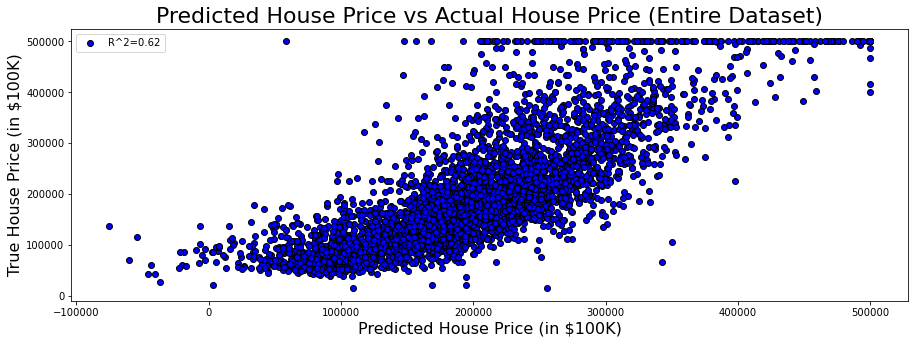

In [30]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price (Entire Dataset)", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [31]:
super_results.loc['R^2 censored', 'MCMC scaled normal'] = r2_score(y_test, y_pred)
print(r2_score(y_test, y_pred))

0.6239192576922457


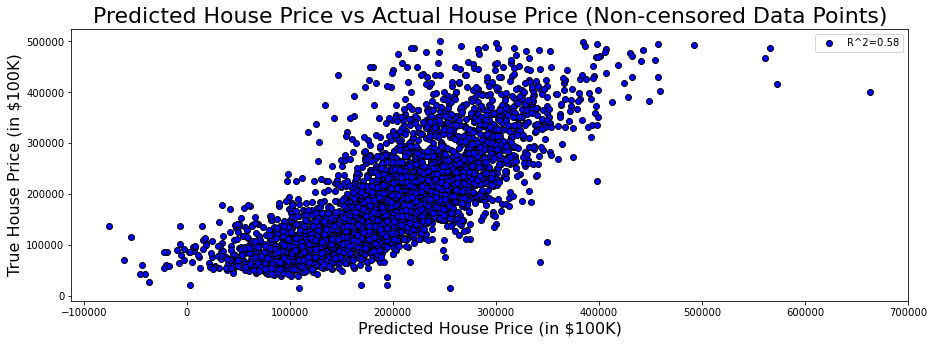

In [32]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price (Non-censored Data Points)", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [33]:
super_results.loc['R^2 small', 'MCMC scaled normal'] = r2_score(y_small, y_pred_small)
print(r2_score(y_small, y_pred_small))

0.5762361151063129


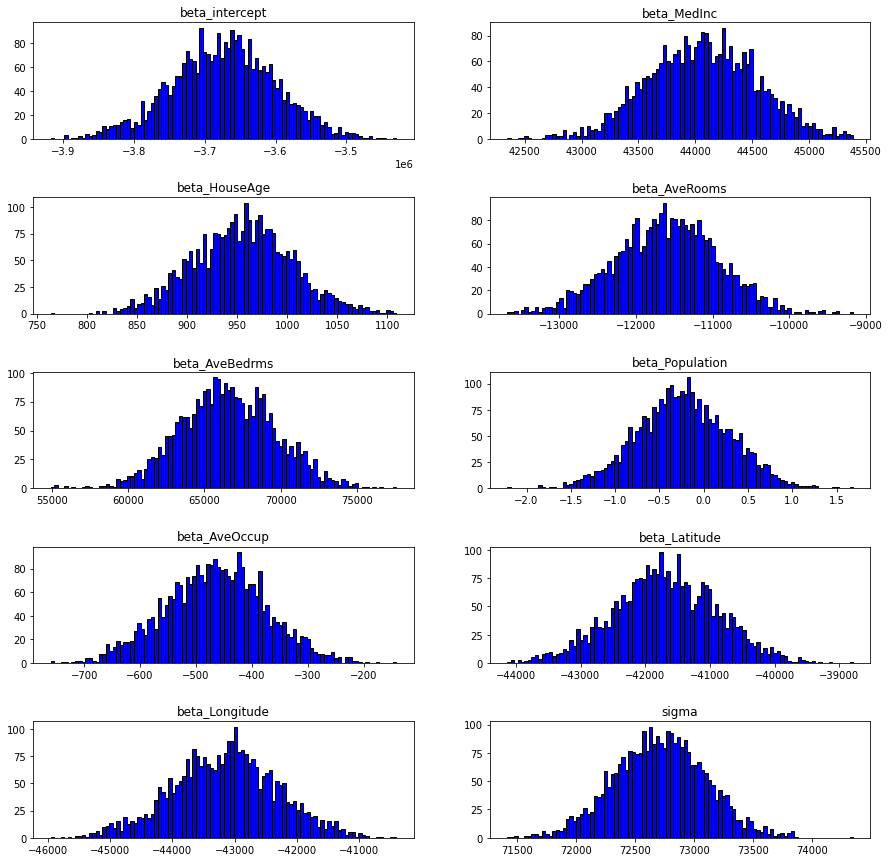

In [34]:
draw_coefficients(beta2_df)

It seems like we got a comparable performance.

However, we can actually employ Pyro to do better! Recall that we saw our house prices are not normally distributed but in fact follow a Gamma distribution. We can modify our code to reflect that in the model.

## Gamma Distribution

In order to better reflect the house distribution, we can employ a Gamma distribution for our target values. Unlike the Normal distribution which is defined by its mean and standard deviation, the Gamma distribution is defined by two positive parameters which are the shape and the rate.

When constructing our model for a distribution other than normal, we need to employ a **link function** which will translate the linear combination of our parameters to the expected value, or the mean, of the distribution. We also would like to know the relationship between the mean and the distribution parameters. Luckily, for the Gamma distribution this is predefined as:

$$\mu = \frac{shape}{rate}$$

However, if both the shape and rate parameters are positive, that means the mean must be positive as well. We need to make sure that our link function captures that. Therefore, I will use the following link function for the linear equation:

$$ln(\mu) = ln(y') = \beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n}$$

or 

$$y' = e^{\beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n}}$$.


Interestingly enough, to recover the coefficients for the unscaled data, the math works out fairly similarly except for the constant. Keeping in mind that:

$$y' = \frac{y}{max(y)}$$

and that

$$ln(\frac{y}{max(y)}) = ln(y) - ln(max(y))$$

We can find that our equation can be written as:

$$ln(y) = \big(ln(max(y)) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\mu_i}{\sigma_i} \big) + \frac{\beta'_1}{\sigma_1}x_1 + \frac{\beta'_2}{\sigma_2}x_2 + ... + \frac{\beta'_n}{\sigma_n}x_n  $$

or 

$$y = e^{\big(ln(max(y)) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\mu_i}{\sigma_i} \big) + \frac{\beta'_1}{\sigma_1}x_1 + \frac{\beta'_2}{\sigma_2}x_2 + ... + \frac{\beta'_n}{\sigma_n}x_n}$$

In [53]:
def model_gamma(X, y, column_names):
    
    min_value = torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max
    
    # We still need to calculate our linear combination
    
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
        
    # But now our mean will be e^{linear combination}
    mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)
    
    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfCauchy(scale=10.0)).clamp(min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate).clamp(min=min_value, max=max_value)
    
    
    
    # Now that we have the shape and rate parameters for the
    # Gamma distribution, we can draw samples from it and condition
    # them on our observations
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        observation = pyro.sample("obs", outcome_dist, obs=y)

You'll notice our code is slightly different but we are still calculating a linear combination of our X data and our coefficients, except now we take the `exp` of that combination to get the expected value of our data point. 
We also sample a rate parameter, and use the mean and rate to calculate the appropriate shape parameter.

Given our shape and rate parameters, we can define a Gamma distribution and ask Pyro to optimize the values this distribution depends on (namely, our coefficients and rate parameters) in order to build a model most likely based on our data.

Let's optimize this new model and look at the results

In [54]:
from sklearn.preprocessing import StandardScaler

my_x_scaler = StandardScaler()

X_train_scaled = my_x_scaler.fit_transform(X_train)

y_max = y_train.max()
y_train_scaled = y_train/y_max

X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


pyro.clear_param_store()
my_kernel = NUTS(model_gamma, max_tree_depth=7)


my_mcmc3 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)



start_time = time.time()
my_mcmc3.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')
super_results.loc['runtime', 'MCMC gamma'] = round(end_time -  start_time, 2)



my_mcmc3.summary()

Sample: 100%|██████████| 3100/3100 [17:11,  3.00it/s, step size=3.23e-03, acc. prob=0.949]


Inference ran for 1031.93 seconds

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept     -0.99      0.00     -0.99     -0.99     -0.98   2850.70      1.00
      beta_MedInc      0.24      0.00      0.24      0.24      0.25    931.73      1.00
    beta_HouseAge      0.04      0.00      0.04      0.04      0.05   2465.17      1.00
    beta_AveRooms      0.02      0.01      0.02      0.01      0.03    709.50      1.00
   beta_AveBedrms      0.00      0.01      0.00     -0.01      0.01    641.20      1.00
  beta_Population      0.03      0.00      0.03      0.03      0.04   2476.77      1.00
    beta_AveOccup     -1.11      0.03     -1.11     -1.15     -1.07    715.14      1.00
    beta_Latitude     -0.65      0.01     -0.65     -0.66     -0.63   2643.40      1.00
   beta_Longitude     -0.58      0.01     -0.58     -0.59     -0.57   2699.82      1.00
             rate     23.20      0.25     23.20     22.78     23.60   3188.77      1.

In [55]:
beta3_df = pd.DataFrame(my_mcmc3.get_samples())
beta3_df = create_beta_df(beta3_df, my_x_scaler, california.feature_names)

# Notice now we have to use the y_max value slightly differently
beta3_df['beta_intercept'] += np.log(y_max)
#beta3_df *= y_max

Let's compare this models performance by calculating the predictions and comparing them to the observed values

In [57]:
linear_combination = predict_linear_combination(beta3_df, X_test)

In [58]:
# We have to take the EXP of the linear combination now to get the expected values
y_pred = np.exp(linear_combination)
#y_pred = torch.nn.functional.softplus(torch.tensor(linear_combination))
#y_pred = linear_combination

# Again, compare for both the censored and uncensored datasets
y_pred_small = y_pred[y_test<max_threshold]
y_pred= np.where(y_pred > max_threshold, max_threshold, y_pred)

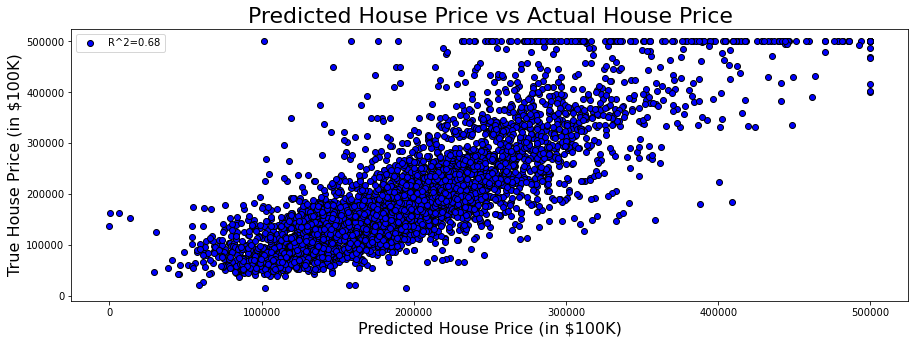

In [59]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [60]:
super_results.loc['R^2 censored', 'MCMC gamma'] = r2_score(y_test, y_pred)
print(r2_score(y_test, y_pred))

0.675106691823083


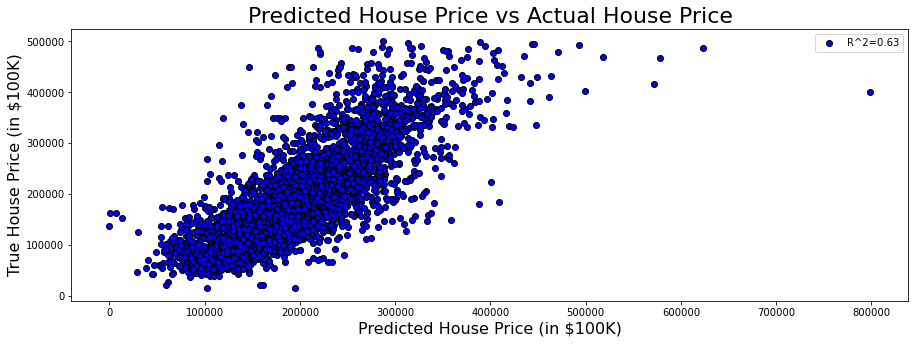

In [61]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

In [62]:
super_results.loc['R^2 small', 'MCMC gamma'] = r2_score(y_small, y_pred_small)
print(r2_score(y_small, y_pred_small))

0.6280239600324367


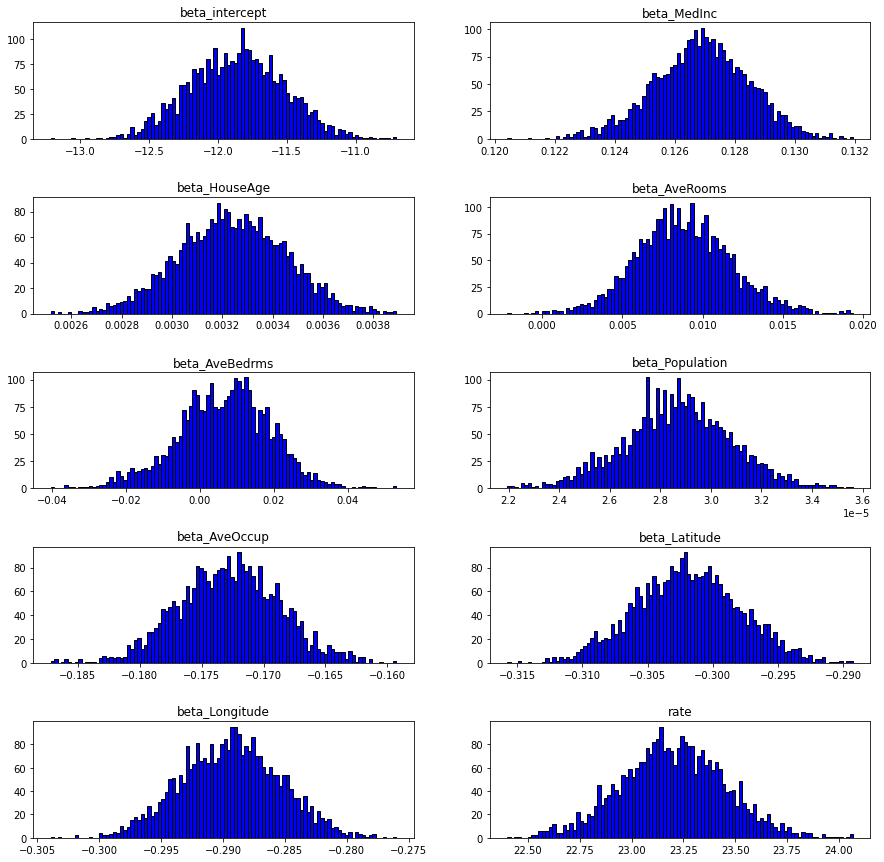

In [63]:
draw_coefficients(beta3_df)

We can notice a few interesting differences between the qualitative conclusions this model gives us as opposed to the Normal distribution model:
* First, under the Normal distribution assumption, it seemed that the house price decreases for each additional room, but under the Gamma distribution assumption, the price seems to increase.
* Second, under the Normal distribution assumption, the price seems to increase for each additional bedroom of the house, but under the Gamma distribution assumption, that conclusion does not seem as certain anymore. 

Other parameters seem to qualitatively agree between the two models. However, we want to be certain we correctly identified the quantitative values of the parameters, and we need to account for the censored data to do that.

## SVI

In [64]:
from torch.distributions import constraints
def guide_gamma(X, y, feature_names):
    pyro.enable_validation(True) 
    
    
    mu_intercept = pyro.param("mu_intercept", 
                              torch.tensor(0.0))
    sigma_intercept = pyro.param("sigma_intercept", 
                                 torch.tensor(1.0), 
                                 constraint=constraints.positive)

    # Again find the linear combination
    intercept = pyro.sample(f"beta_intercept", 
                            dist.Normal(mu_intercept, sigma_intercept))
    
    
    min_value = torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max
    
    
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        mu_beta = pyro.param(f"mu_{column_names[i]}", 
                             torch.tensor(0.0))
        
        sigma_beta = pyro.param(f"sigma_{column_names[i]}", 
                                torch.tensor(1.0), 
                                constraint=constraints.positive)
        
        coefficient_prior = dist.Normal(mu_beta, sigma_beta)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
    

    # Let's try and fit a Gamma distribution on the rate parameter
    
    shape_r = pyro.param("shape_r", torch.tensor(10.0), constraint=constraints.positive)
    rate_r = pyro.param("rate_r", torch.tensor(10.0), constraint=constraints.positive)

    
    rate = pyro.sample("rate", dist.Gamma(shape_r, rate_r))
    
        

In [68]:
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from pyro.infer import Predictive
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

# Scale the data
X_train_scaled = my_x_scaler.fit_transform(X_train)

y_max = y_train.max()
y_train_scaled = y_train/y_max

X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)



pyro.clear_param_store()
#my_guide = guide_gamma_cen
my_guide = AutoDiagonalNormal(model_gamma)



my_svi = SVI(model=model_gamma,
             guide= my_guide,
             optim=ClippedAdam({"lr": 0.01, 'clip_norm': 1.0}),
             loss=TraceGraph_ELBO())

losses = []

start_time = time.time()
for i in range(10000):

    loss = my_svi.step(X_train_torch,
                       y_train_torch,  
                       california.feature_names)
    
    normalized_loss = loss/X_train_torch.shape[0]
    losses.append(normalized_loss)
    if (i % 1000 == 0):
        print(f'iter: {i}, normalized loss:{round(normalized_loss,2)}')
        
        

predictive = Predictive(model=model_gamma,
                        guide= my_guide,
                        num_samples=SAMPLE_NUMBER) 

samples = predictive(X_train_torch,
                     y_train_torch,  
                     california.feature_names)

        
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

super_results.loc['runtime', 'SVI gamma'] = round(end_time -  start_time, 2)





iter: 0, normalized loss:29.27
iter: 1000, normalized loss:-0.67
iter: 2000, normalized loss:-0.67
iter: 3000, normalized loss:-0.67
iter: 4000, normalized loss:-0.67
iter: 5000, normalized loss:-0.67
iter: 6000, normalized loss:-0.67
iter: 7000, normalized loss:-0.67
iter: 8000, normalized loss:-0.67
iter: 9000, normalized loss:-0.67
Inference ran for 61.02 seconds


In [69]:
beta_svi_df = {}
for key, values in samples.items():
    if ("beta_" in key) or ("rate" in key):
        if ("beta_coefficients" in key):
            values = values.view(values.shape[0], values.shape[-1])
        else:
            values = values.view(values.shape[0], )
        
        beta_svi_df[key] = values.detach()
        
beta_svi_df = pd.DataFrame(beta_svi_df)



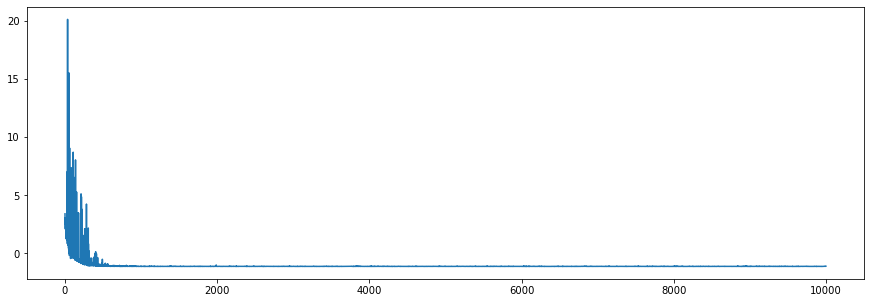

In [70]:
losses = np.array(losses)

plt.figure(figsize=(15,5))
plt.plot(np.log(losses+1))
plt.show()

In [71]:
beta_svi_df = create_beta_df(beta_svi_df, my_x_scaler, california.feature_names)
beta_svi_df['beta_intercept'] += np.log(y_max)

In [72]:
linear_combination = predict_linear_combination(beta_svi_df, X_test)

In [73]:
y_pred = np.exp(linear_combination)
y_pred_small = y_pred[y_test<max_threshold]
y_pred= np.where(y_pred > max_threshold, max_threshold, y_pred)

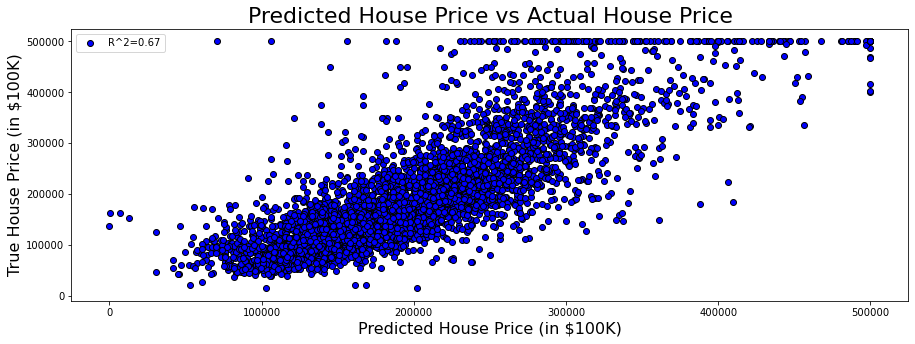

In [74]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [81]:
super_results.loc['R^2 censored', 'SVI gamma'] = r2_score(y_test, y_pred)
print(r2_score(y_test, y_pred))

0.6749195717975099


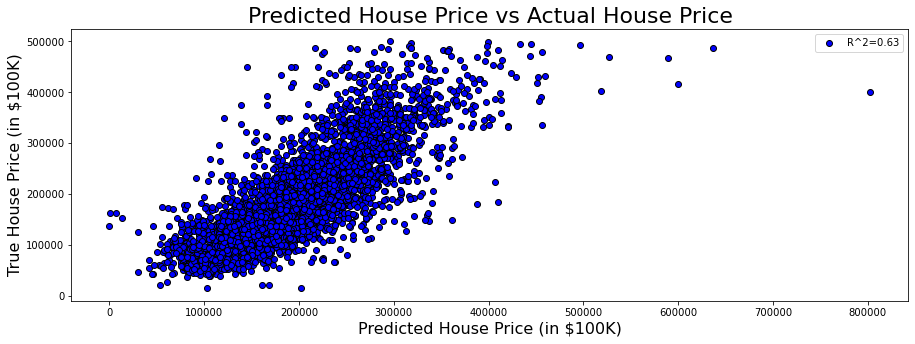

In [82]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.ticklabel_format(style='plain')
plt.show()

In [83]:
super_results.loc['R^2 small', 'SVI gamma'] = r2_score(y_small, y_pred_small)
print(r2_score(y_small, y_pred_small))

0.6263937919996319


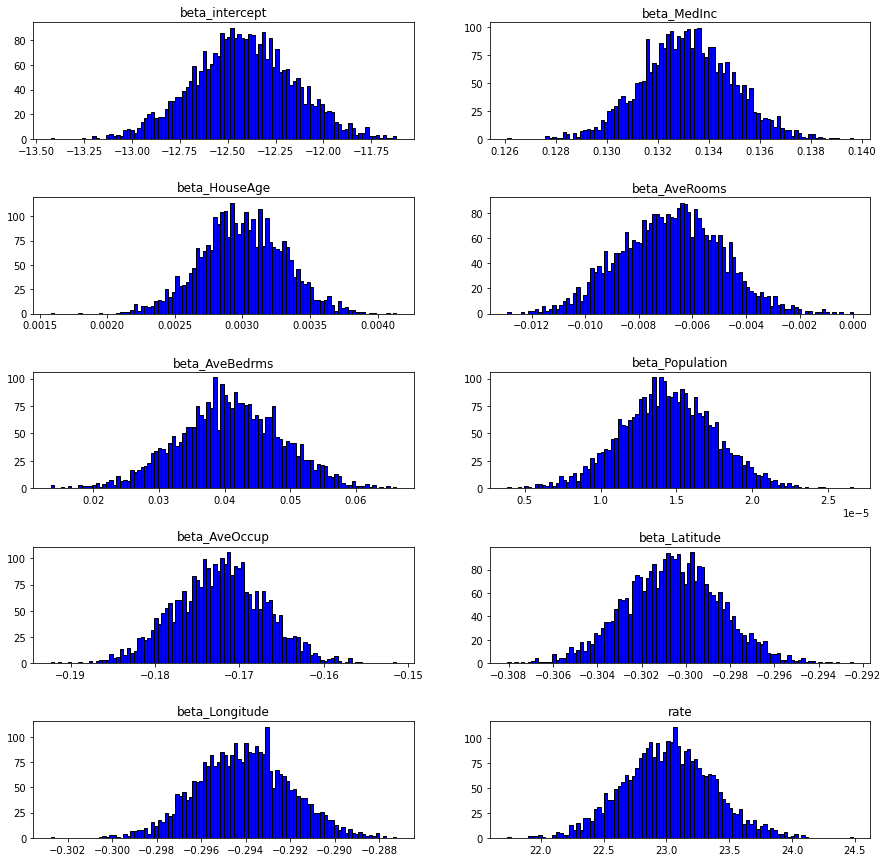

In [84]:
draw_coefficients(beta_svi_df)

In [85]:
super_end = time.time()

print(f'Notebook runtime: {round((super_end -  super_start)/60, 2)} minutes')


Notebook runtime: 293.39 minutes


In [86]:
super_results

,LR,MCMC unscaled normal,MCMC scaled normal,MCMC gamma,SVI gamma,SVI gamma+cen
runtime,0.000000,1486.010000,807.970000,1031.930000,61.020000,NaN
R^2 censored,0.623933,-1.583936,0.429638,0.675107,0.674920,0.674920
R^2 small,0.576249,-1.816711,0.217009,0.628024,0.626394,0.626394


In [87]:
assert(False)

AssertionError: 

# END

In [ ]:
class BorisGamma(dist.Gamma):
    
    
    def _incomplete_lower_gamma(self, s_values, x_values):
        result = 0.0
        
        log_coef = s_values * torch.log(x_values) + torch.lgamma(s_values) - x_values
        #coef = torch.exp(log_coef)
        
        for k in range(20):
            numerator = x_values**k
            
            denominator = torch.exp(torch.lgamma(s_values + k + 1))
            
            
            result += numerator/denominator
            
        log_result = torch.log(result)
            
        log_lower_gamma = log_coef + log_result
        
        lower_gamma = torch.exp(log_lower_gamma)
        
        
        return lower_gamma
    
    
    def cdf(self, y_values):
        
        y_values = torch.as_tensor(y_values, dtype=self.rate.dtype, device=self.rate.device)
        
        
        
        term1 = 1/torch.exp(torch.lgamma(self.concentration))
        term2 = self._incomplete_lower_gamma(self.concentration, self.rate * y_values)
        
        return term1 * term2

## Gamma + Censored data

For any given house, we assume that its price comes from a Gamma distribution. However, we've observed in our data that if a house price is above \\$500,000, that price will be censored. The question becomes, how do we quantify this in our model.

We can ask ourselves, "For a given house, what is the probability that its price will be censored?"

The answer is that the probability is the same as the probability that the house price will be above \\$500,000. Well we have a clear way to ask a distribution for the probability a value will be below some threshold, it is the Cumulative Distribution Function (CDF) at that threshold. So 1 - CDF(500,000) will give us the probability that a house value will be above \\$500,000.

We will use that information and add that to the model. We'll say that if the model sees a value below \\$500,000, that is the observed value of the house. But if the model sees a value of \\$500,000, the probability of observing that censoring is the result of a Bernoulli trial, with the probability of censoring "success" being 1-CDF(500,000).

In [ ]:
from scipy.stats import gamma as scipygamma

def model_gamma_cen(X, y, censored_label):
    pyro.enable_validation(True) 
    
    
    min_value = torch.finfo(X.dtype).eps
    max_p_value = 1.0 - torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max/1000
    
    
    # We still need to calculate our linear combination
    
    intercept_prior = dist.Normal(torch.tensor(0.0), 
                                  torch.tensor(1.0))
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    coefficients_prior = dist.Normal(torch.tensor(0.0), 
                                     torch.tensor(1.0)).expand([X.shape[1]]) 
    
    coefficients_prior = coefficients_prior.to_event(1)
    
    betas = pyro.sample(f"beta_coefficients", coefficients_prior)
    
    
    # Finally, calculate the linear combination of parameters and X values
    linear_combination = linear_combination + torch.matmul(X, betas)
    
    
    # But now our mean will be e^{linear combination}
    mean = torch.exp(linear_combination).clamp(min=min_value)
    
    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfCauchy(scale=torch.tensor(10.0))).clamp(min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate).clamp(min=min_value, max=max_value)
    
    
    
    # The data is now divided into two outcomes: censored, and non-censored
    with pyro.plate("data", y.shape[0]):
        
                
        outcome_dist = BorisGamma(shape, rate)
        
        
        # If it is not censored, our observations are the directly observed
        # values of y
        with pyro.poutine.mask(mask = (censored_label == 0.0)):
            observation = pyro.sample("obs", 
                                      outcome_dist, 
                                      obs=y)
            
        # If it is censored, our observations are the observed
        # censoring lables, and those come from
        # a Bernoulli distribution where the probability
        # of censoring is defined by the CDF of the Gamma distribution
        with pyro.poutine.mask(mask = (censored_label == 1.0)):

            truncation_prob = 1.0 - outcome_dist.cdf(y).clamp(min=min_value, max=max_p_value)
            
            try:
                censored_observation = pyro.sample("censorship",
                                                   dist.Bernoulli(truncation_prob),
                                                   obs=torch.tensor(1.0))
            except:
                print(truncation_prob)
                print(truncation_prob.min(), truncation_prob.max())
                print(y.min(), y.max())
                print(shape.min(), shape.max())
                print(rate)
        
        

Notice since `pyro` doesn't yet implement a CDF method for its Gamma distribution I had to use the Gamma distribution from `scipy`.

Now we can run our model again, but this time sending both the observed prices and observed censoring of data.

In [ ]:
from sklearn.preprocessing import StandardScaler



X_train_scaled = my_x_scaler.fit_transform(X_train)

y_max = y_train.max()
#y_train_scaled = y_train/y_max

y_train_scaled = np.log(y_train)

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float64)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float64)

# Find censored labels
numpy_censored_label = np.where(y_train >= y_max, 1.0, 0.0)
censored_label = torch.tensor(numpy_censored_label, dtype=torch.float64)





pyro.clear_param_store()
my_kernel = NUTS(model_gamma_cen, max_tree_depth=7)


my_mcmc4 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER//3,
                warmup_steps=100)


start_time = time.time()
my_mcmc4.run(X_train_torch,
             y_train_torch,  
             censored_label)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

super_results.loc['runtime', 'MCMC gamma+cen'] = round(end_time -  start_time, 2)



my_mcmc4.summary()

In [ ]:
plt.hist(np.log(scipygamma(a=4.0, scale=1/4.0).rvs(100000)+1), bins=100);

In [ ]:
beta4_df = pd.DataFrame(my_mcmc4.get_samples())
beta4_df = create_beta_df(beta4_df, my_x_scaler, california.feature_names)

beta4_df['beta_intercept'] += np.log(y_max)

In [ ]:
linear_combination = predict_linear_combination(beta4_df, X_test)

In [ ]:
y_pred = np.exp(linear_combination)
y_pred_small = y_pred[y_test<max_threshold]
y_pred= np.where(y_pred > max_threshold, max_threshold, y_pred)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
plt.hist(dist.Gamma(4.0, 5.0).rsample([100000]).numpy(), bins=100);
plt.hist(scipygamma.rvs(a=4.0,scale=1/5.0, size=100000), bins=100);
plt.xlim(0.0, 10.0)

In [ ]:
super_results.loc['R^2 censored', 'MCMC gamma+cen'] = r2_score(y_test, y_pred)
print(r2_score(y_test, y_pred))

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
super_results.loc['R^2 small', 'MCMC gamma+cen'] = r2_score(y_small, y_pred_small)
print(r2_score(y_small, y_pred_small))

In [ ]:
draw_coefficients(beta4_df)

## Gamma + Censored data (old)

For any given house, we assume that its price comes from a Gamma distribution. However, we've observed in our data that if a house price is above \\$500,000, that price will be censored. The question becomes, how do we quantify this in our model.

We can ask ourselves, "For a given house, what is the probability that its price will be censored?"

The answer is that the probability is the same as the probability that the house price will be above \\$500,000. Well we have a clear way to ask a distribution for the probability a value will be below some threshold, it is the Cumulative Distribution Function (CDF) at that threshold. So 1 - CDF(500,000) will give us the probability that a house value will be above \\$500,000.

We will use that information and add that to the model. We'll say that if the model sees a value below \\$500,000, that is the observed value of the house. But if the model sees a value of \\$500,000, the probability of observing that censoring is the result of a Bernoulli trial, with the probability of censoring "success" being 1-CDF(500,000).

In [ ]:
from scipy.stats import gamma as scipygamma

def model_gamma_cen(X, y, censored_label):
    pyro.enable_validation(True) 
    
    
    min_value = torch.finfo(X.dtype).eps
    max_value = 1.0 - torch.finfo(X.dtype).eps
    
    
    # We still need to calculate our linear combination
    
    intercept_prior = dist.Normal(torch.tensor(0.0), 
                                  torch.tensor(1.0))
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    coefficients_prior = dist.Normal(torch.tensor(0.0), 
                                     torch.tensor(1.0)).expand([X.shape[1]]) 
    
    coefficients_prior = coefficients_prior.to_event(1)
    
    betas = pyro.sample(f"beta_coefficients", coefficients_prior)
    
    
    # Finally, calculate the linear combination of parameters and X values
    linear_combination = linear_combination + torch.matmul(X, betas)
    
    
    # But now our mean will be e^{linear combination}
    mean = torch.exp(linear_combination).clamp(min=min_value)
    
    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfCauchy(scale=torch.tensor(10.0))).clamp(min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate).clamp(min=min_value)
    
    
    
    # The data is now divided into two outcomes: censored, and non-censored
    with pyro.plate("data", y.shape[0]):
        
                
        outcome_dist = dist.Gamma(shape, rate)
        
        
        # If it is not censored, our observations are the directly observed
        # values of y
        with pyro.poutine.mask(mask = (censored_label == 0.0)):
            observation = pyro.sample("obs", 
                                      outcome_dist, 
                                      obs=y)
            
        # If it is censored, our observations are the observed
        # censoring lables, and those come from
        # a Bernoulli distribution where the probability
        # of censoring is defined by the CDF of the Gamma distribution
        with pyro.poutine.mask(mask = (censored_label == 1.0)):

            shape_np = shape.detach().numpy().astype(np.float32)
            rate_np = rate.detach().item()
            
            truncation_probabilities_np = (scipygamma(a=shape_np, scale=1.0/rate_np).sf(y))
            
            
            
            
            truncation_prob = torch.tensor(truncation_probabilities_np).clamp(min=min_value,
                                                                              max=max_value)
            #print(truncation_prob.min(), truncation_prob.max())
            
            censored_observation = pyro.sample("censorship",
                                               dist.Bernoulli(truncation_prob),
                                               obs=torch.tensor(1.0))
        

In [ ]:
 from scipy.stats import gamma as scipygamma

    def model_gamma_cen(X, y, censored_label):
    
    
        min_value = torch.finfo(X.dtype).eps
        max_p_value = 1.0 - torch.finfo(X.dtype).eps
        max_value = torch.finfo(X.dtype).max/100.0
    
    
        # Prior on the intercept
    
        intercept_prior = dist.Normal(0.0, 1.0)
        linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
        # Also define coefficient priors
        coefficients_prior = dist.Normal(0.0, 1.0).expand([X.shape[1]]) 
        betas = pyro.sample(f"beta_coefficients", coefficients_prior)
    
    
        # Finally, calculate the linear combination of parameters and X values
        linear_combination = linear_combination + torch.matmul(X, betas)
    
    
        # But now our mean will be e^{linear combination}, I'm using a link 
        # function log(mu)  = linear combo of X
        mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)
    
        # We will also define a rate parameter
        rate = pyro.sample("rate", dist.HalfCauchy(scale=10.0).clamp(min=min_value)
    
        # Since mean = shape/rate, then the shape = mean * rate
        shape = (mean * rate)
    
        # The data is now divided into two outcomes: censored, and non-censored
        rate_np = rate.detach().item()
    
        with pyro.plate("data", y.shape[0]):
            # If the data is not censored, we just observe the y value and it's
            # dictated by the Gamma distribution
            with pyro.poutine.mask(mask = (censored_label == 0.0)):
                observation = pyro.sample("obs", dist.Gamma(shape, rate), obs=y)

            # If the data is censored, we need to calculate the 1-CDF of the Gamma function
            # we will use the CDF implementation in scipy.stats.gamma
            
            with pyro.poutine.mask(mask = (censored_label == 1.0)):
                scipy_gamma_dist = scipygamma(a=shape.detach().numpy(), scale=1/rate.detach().numpy())
                
                # find truncation probability
                truncation_probability_np = 1.0 - scipy_gamma_dist.cdf(y.detach().numpy())
                truncation_prob = torch.tensor(truncation_probability_np).clamp(min=min_value, max=max_p_value)
        
                censored_observation = pyro.sample(f"censorship", dist.Bernoulli(truncation_prob), obs=torch.tensor(1.0)

In [ ]:
def model_normal_cen(X, y, column_names, censoring_label):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    # Define a sigma value for the random error
    sigma = pyro.sample("sigma", dist.HalfCauchy(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        with pyro.poutine.mask(mask=(censoring_label == 0.0)):
            # Condition the expected mean on the observed target y
            observation = pyro.sample("obs", outcome_dist, obs=y)
        
        with pyro.poutine.mask(mask=(censoring_label == 1.0)):
            
            truncation_proba = 1.0 - outcome_dist.cdf(y)
            
            
            truncation_label = pyro.sample("obs_censored",
                                           dist.Bernoulli(probs=truncation_proba), 
                                           obs=torch.tensor(1.0))

Notice since `pyro` doesn't yet implement a CDF method for its Gamma distribution I had to use the Gamma distribution from `scipy`.

Now we can run our model again, but this time sending both the observed prices and observed censoring of data.

In [ ]:
from sklearn.preprocessing import StandardScaler



X_train_scaled = my_x_scaler.fit_transform(X_train)

#y_max = y_train.max()
#y_train_scaled = y_train/y_max

y_train_log = np.log(y_train)
y_max = y_train_log.max()
y_train_scaled = y_train_log/y_max

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float64)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float64)

# Find censored labels
numpy_censored_label = np.where(y_train >= y_max, 1.0, 0.0)
censored_label = torch.tensor(numpy_censored_label, dtype=torch.float64)





pyro.clear_param_store()
my_kernel = NUTS(model_normal_cen, max_tree_depth=7)


my_mcmc4 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc4.run(X_train_torch,
             y_train_torch,  
             california.feature_names,
             censored_label)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

super_results.loc['runtime', 'MCMC gamma+cen'] = round(end_time -  start_time, 2)



my_mcmc4.summary()

In [ ]:
beta4_df = pd.DataFrame(my_mcmc4.get_samples())

In [ ]:
beta4_df = pd.DataFrame(my_mcmc4.get_samples())
beta4_df = create_beta_df(beta4_df, my_x_scaler, california.feature_names)

#beta4_df['beta_intercept'] *= y_max

In [ ]:
linear_combination = predict_linear_combination(beta4_df, X_train)

In [ ]:
plt.scatter(linear_combination, y_train_log)

In [ ]:
y_pred = np.exp(linear_combination)
y_pred_small = y_pred[y_test<max_threshold]
y_pred= np.where(y_pred > max_threshold, max_threshold, y_pred)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
super_results.loc['R^2 censored', 'MCMC gamma+cen'] = r2_score(y_test, y_pred)
print(r2_score(y_test, y_pred))

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
super_results.loc['R^2 small', 'MCMC gamma+cen'] = r2_score(y_small, y_pred_small)
print(r2_score(y_small, y_pred_small))

In [ ]:
draw_coefficients(beta4_df)

## SVI

In [ ]:
from torch.distributions import constraints
def guide_gamma_cen(X, y, censored_label):
    pyro.enable_validation(True) 
    
    
    mu_intercept = pyro.param("mu_intercept", 
                              torch.tensor(0.0))
    sigma_intercept = pyro.param("sigma_intercept", 
                                 torch.tensor(1.0), 
                                 constraint=constraints.positive)

    # Again find the linear combination
    linear_combination = pyro.sample(f"beta_intercept", 
                                     dist.Normal(mu_intercept, sigma_intercept))
    
    
    mu_coef = pyro.param(f"mu_betas", 
                         torch.zeros(X.shape[1]))
    sigma_coef = pyro.param(f"sigma_betas", 
                            torch.ones(X.shape[1]), 
                            constraint=constraints.positive)
        
    betas = pyro.sample(f"beta_coefficients", dist.Normal(mu_coef, 
                                                          sigma_coef).expand([X.shape[1]]).to_event(1))
    

    # Let's try and fit a Gamma distribution on the rate parameter
    
    shape_r = pyro.param("shape_r", torch.tensor(10.0), constraint=constraints.positive)
    rate_r = pyro.param("rate_r", torch.tensor(10.0), constraint=constraints.positive)

    
    rate = pyro.sample("rate", dist.Gamma(shape_r, rate_r))
    
        

In [ ]:
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from pyro.infer import Predictive
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

# Scale the data
X_train_scaled = my_x_scaler.fit_transform(X_train)

y_max = y_train.max()
y_train_scaled = y_train/y_max

X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)

# Find censored labels
numpy_censored_label = np.where(y_train >= y_max, 1.0, 0.0)
censored_label = torch.tensor(numpy_censored_label)





pyro.clear_param_store()
#my_guide = guide_gamma_cen
my_guide = AutoDiagonalNormal(model_gamma_cen)



my_svi = SVI(model=model_gamma_cen,
             guide= my_guide,
             optim=ClippedAdam({"lr": 0.01, 'clip_norm': 1.0}),
             loss=TraceGraph_ELBO())

losses = []

start_time = time.time()
for i in range(10000):

    loss = my_svi.step(X_train_torch,
                       y_train_torch,  
                       censored_label)
    
    normalized_loss = loss/X_train_torch.shape[0]
    losses.append(normalized_loss)
    if (i % 1000 == 0):
        print(f'iter: {i}, normalized loss:{round(normalized_loss,2)}')
        
        

predictive = Predictive(model=model_gamma_cen,
                        guide= my_guide,
                        num_samples=SAMPLE_NUMBER) 

samples = predictive(X_train_torch,
                     y_train_torch,  
                     censored_label)

        
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

super_results.loc['runtime', 'SVI gamma+cen'] = round(end_time -  start_time, 2)





In [ ]:
beta_svi_df = {}
for key, values in samples.items():
    if ("beta_" in key) or ("rate" in key):
        if ("beta_coefficients" in key):
            values = values.view(values.shape[0], values.shape[-1])
        else:
            values = values.view(values.shape[0], )
        
        beta_svi_df[key] = values.detach()
        
beta_svi_df = pd.DataFrame(beta_svi_df)



In [ ]:
losses = np.array(losses)

plt.figure(figsize=(15,5))
plt.plot(np.log(losses+1))
plt.show()

In [ ]:
beta_svi_df = create_beta_df(beta_svi_df, my_x_scaler, california.feature_names)
beta_svi_df['beta_intercept'] += np.log(y_max)

In [ ]:
linear_combination = predict_linear_combination(beta_svi_df, X_test)

In [ ]:
y_pred = np.exp(linear_combination)
y_pred_small = y_pred[y_test<max_threshold]
y_pred= np.where(y_pred > max_threshold, max_threshold, y_pred)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_test, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_test, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
super_results.loc['R^2 censored', 'SVI gamma+cen'] = r2_score(y_test, y_pred)
print(r2_score(y_test, y_pred))

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.ticklabel_format(style='plain')
plt.show()

In [ ]:
super_results.loc['R^2 small', 'SVI gamma+cen'] = r2_score(y_small, y_pred_small)
print(r2_score(y_small, y_pred_small))

In [ ]:
draw_coefficients(beta_svi_df)

In [ ]:
super_end = time.time()

print(f'Notebook runtime: {round((super_end -  super_start)/60, 2)} minutes')


In [ ]:
super_results